In [1]:
import os
import json
import pandas as pd
import numpy as np
import itertools
from pathlib import Path
from concurrent import futures

# plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# scoot functions
from cleanair.scoot import (
    generate_fp,
    load_model_from_file,
    load_processed_data_from_file,
    plotly_results,
    percentage_coverage
)

## Load the data

Specify the `name` of the experiment and the `period` (i.e. normal or lockdown). From here all the raw data will be loaded and the filepaths setup.

In [2]:
name = "monday"     # the name of the experiment to load
prefix="normal"     # look at a normal period or lockdown period?

# make the figure directory
user_settings_fp = os.path.join("..", "..", "terraform", ".secrets", "user_settings.json")
with open(user_settings_fp) as json_file:
    user_settings = json.load(json_file)
xpfp = user_settings["experiment_dir"]  # root to experiments filepaths directory
figure_dir = os.path.join(xpfp, name, "figures")
settings_dir = os.path.join(xpfp, name, "settings")
Path(figure_dir).mkdir(exist_ok=True)

# get the settings for kernels and scoot data
with open(os.path.join(settings_dir, "kernel_settings.json")) as kernel_file:
    kernel_settings = json.load(kernel_file)
with open(os.path.join(settings_dir, "scoot_settings.json")) as scoot_file:
    scoot_settings = json.load(scoot_file)

# load the raw csv
normal_df = pd.read_csv(generate_fp(name, xp_root=xpfp))
normal_df = normal_df.loc[
    (normal_df.measurement_start_utc >= scoot_settings["normal_start"]) &
    (normal_df.measurement_start_utc < scoot_settings["normal_end"])
]
lockdown_df = pd.read_csv(generate_fp(name, prefix="lockdown", xp_root=xpfp))
lockdown_df = lockdown_df.loc[
    (lockdown_df.measurement_start_utc >= scoot_settings["lockdown_start"]) &
    (lockdown_df.measurement_start_utc < scoot_settings["lockdown_end"])
]

## Single result

See a plot for a single detector for a single model fit.

In [ ]:
# plot the results for just one sensor
detector_id = "N00/002e1"
kernel_id = "rbf_ls=1_v=1"
sensor_df = normal_df.loc[normal_df.detector_id==detector_id]
data = plotly_results(sensor_df, detector_id, model, X, num_samples=1000)
fig = go.Figure(data=data, layout=dict(title="Total vehicles for sensor {id}".format(id=detector_id)))
fig.show()

## Percentage coverage for all results

For every single detector and every single kernel, we are going to calculate the percentage coverage of the fit.

In [5]:
# going to do cross product between these lists later
period_list = [prefix]
detector_list = scoot_settings["scoot_ids"]
kernel_list = list(kernel_settings.keys())

n = 10                  # run coverage algorithm n times for each kernel-data setting
num_samples=1000
num_pertubations=1000

params_list = []

for kernel_id, detector_id, period in itertools.product(kernel_list, detector_list, period_list):
    for k in range(n):
        model = load_model_from_file(name, kernel_id, detector_id, prefix=period, xp_root=xpfp)
        X, Y = load_processed_data_from_file(name, detector_id, prefix=period, xp_root=xpfp)
        params_list.append(dict(
            kernel_id=kernel_id,
            detector_id=detector_id,
            period=period,
            model=model,
            X=X[:,0][:,np.newaxis],
            Y=Y,
            iteration=k
        ))


In [6]:
metric_keys = ["kernel_id", "detector_id", "period", "iteration"]
metrics_df = pd.DataFrame(columns=metric_keys)
number_of_executions = len(params_list)
count = 0
percent = 0

with futures.ThreadPoolExecutor(max_workers=8) as executor:
    # for k in list(kernel_settings.keys()):
    # future_result = executor.map(percentage_coverage, zip(models, X_list, Y_list, [num_samples for i in range(n)], [num_pertubations for i in range(n)]))
    future_to_id = {executor.submit(
        percentage_coverage,
        item["model"],
        item["X"],
        item["Y"],
        num_samples=num_samples,
        num_pertubations=num_pertubations
    ): {key: item[key] for key in metric_keys} for item in params_list}

    for future in futures.as_completed(future_to_id):
        item = future_to_id[future]
        item["coverage"] = future.result()
        if (count / number_of_executions) * 100 >= percent:
            percent = math.ceil((count/number_of_executions) * 100)
            print("{p} %".format(p=percent))
        metrics_df = metrics_df.append(item, ignore_index=True)

0.889
0.887
0.897
0.898
0.905
0.894
0.892
0.895
0.913
0.902
0.893
0.886
0.9
0.9
0.882
0.897
0.887
0.893
0.872
0.901
0.894
0.887
0.898
0.895
0.884
0.889
0.905
0.876
0.905
0.884
0.9
0.9
0.88
0.904
0.889
0.885
0.895
0.893
0.891
0.892
0.899
0.881
0.892
0.884
0.891
0.901
0.883
0.883
0.896
0.908
0.864
0.854
0.865
0.876
0.881
0.864
0.859
0.861
0.863
0.859
0.867
0.875
0.873
0.852
0.879
0.875
0.855
0.835
0.876
0.848
0.604
0.579
0.626
0.616
0.604
0.635
0.617
0.614
0.657
0.635
0.891
0.886
0.899
0.891
0.881
0.894
0.902
0.885
0.902
0.903
0.888
0.881
0.87
0.874
0.871
0.88
0.869
0.863
0.881
0.874
0.841
0.837
0.868
0.831
0.838
0.842
0.824
0.846
0.853
0.841
0.917
0.903
0.909
0.902
0.899
0.908
0.907
0.909
0.907
0.906
0.834
0.814
0.795
0.831
0.812
0.8
0.816
0.807
0.812
0.881
0.821
0.867
0.855
0.861
0.88
0.867
0.857
0.868
0.87
0.858
0.872
0.874
0.853
0.865
0.865
0.874
0.88
0.871
0.822
0.856
0.874
0.878
0.872
0.862
0.837
0.857
0.848
0.879
0.837
0.854
0.836
0.82
0.865
0.863
0.826
0.833
0.847
0.84
0.829
0.85

In [10]:
metrics_df.to_csv(os.path.join(xpfp, name, "results", "percentage_coverage.csv"))
metrics_df

,kernel_id,detector_id,period,iteration,coverage
0,rbf_ls=0.1_v=0.1,N00/002e1,normal,6,0.889
1,rbf_ls=0.1_v=0.1,N00/002e1,normal,4,0.887
2,rbf_ls=0.1_v=0.1,N00/002e1,normal,3,0.897
3,rbf_ls=0.1_v=0.1,N00/002e1,normal,0,0.898
4,rbf_ls=0.1_v=0.1,N00/002e1,normal,5,0.905
...,...,...,...,...,...
235,matern32_ls=1_v=1,N13/016a1,normal,5,0.861
236,matern32_ls=1_v=1,N13/016a1,normal,6,0.858
237,matern32_ls=1_v=1,N13/016a1,normal,7,0.875
238,matern32_ls=1_v=1,N13/016a1,normal,8,0.851


In [8]:
metric_gb = metrics_df.groupby(["kernel_id", "detector_id", "period"])
metric_gb.describe()

coverage                           \
                                            count    mean       std    min   
kernel_id             detector_id period                                     
matern32_ls=0.1_v=0.1 N00/002e1   normal     10.0  0.8142  0.012273  0.795   
                      N00/002g1   normal     10.0  0.8664  0.009021  0.855   
                      N13/016a1   normal     10.0  0.8706  0.007834  0.853   
matern32_ls=0.1_v=1   N00/002e1   normal     10.0  0.8524  0.017122  0.822   
                      N00/002g1   normal     10.0  0.8409  0.015191  0.820   
                      N13/016a1   normal     10.0  0.8615  0.011540  0.842   
matern32_ls=1_v=0.1   N00/002e1   normal     10.0  0.8084  0.009879  0.792   
                      N00/002g1   normal     10.0  0.8052  0.010830  0.791   
                      N13/016a1   normal     10.0  0.8654  0.009489  0.852   
matern32_ls=1_v=1     N00/002e1   normal     10.0  0.8000  0.014376  0.774   
                      N00/002g1   normal     10.0  0.8054  0.012843  0.776   
                      N13/016a1   normal     10.0  0.8620  0.011499  0.846   
rbf_ls=0.1_v=0.1      N00/002e1   normal     10.0  0.8950  0.005292  0.887   
                      N00/002g1   normal     10.0  0.8933  0.011814  0.872   
                      N13/016a1   normal     10.0  0.8928  0.008779  0.876   
rbf_ls=0.1_v=1        N00/002e1   normal     10.0  0.8918  0.008094  0.880   
                      N00/002g1   normal     10.0  0.8918  0.009126  0.881   
                      N13/016a1   normal     10.0  0.8672  0.008613  0.854   
rbf_ls=1_v=0.1        N00/002e1   normal     10.0  0.8609  0.013948  0.835   
                      N00/002g1   normal     10.0  0.6187  0.021323  0.579   
                      N13/016a1   normal     10.0  0.8934  0.007905  0.881   
rbf_ls=1_v=1          N00/002e1   normal     10.0  0.8751  0.007370  0.863   
                      N00/002g1   normal     10.0  0.8421  0.012023  0.824   
                      N13/016a1   normal     10.0  0.9067  0.004877  0.899   

                                                                           
                                              25%     50%      75%    max  
kernel_id             detector_id period                                   
matern32_ls=0.1_v=0.1 N00/002e1   normal  0.80825  0.8130  0.81975  0.834  
                      N00/002g1   normal  0.85875  0.8670  0.86950  0.881  
                      N13/016a1   normal  0.86650  0.8730  0.87400  0.880  
matern32_ls=0.1_v=1   N00/002e1   normal  0.83975  0.8550  0.86075  0.879  
                      N00/002g1   normal  0.83000  0.8380  0.84925  0.865  
                      N13/016a1   normal  0.85425  0.8605  0.87075  0.877  
matern32_ls=1_v=0.1   N00/002e1   normal  0.80600  0.8105  0.81400  0.824  
                      N00/002g1   normal  0.79900  0.8035  0.81275  0.823  
                      N13/016a1   normal  0.85925  0.8670  0.87050  0.882  
matern32_ls=1_v=1     N00/002e1   normal  0.79275  0.8005  0.81025  0.823  
                      N00/002g1   normal  0.80000  0.8095  0.81325  0.820  
                      N13/016a1   normal  0.85275  0.8620  0.86900  0.882  
rbf_ls=0.1_v=0.1      N00/002e1   normal  0.89225  0.8945  0.89775  0.905  
                      N00/002g1   normal  0.88625  0.8950  0.90075  0.913  
                      N13/016a1   normal  0.88750  0.8945  0.89950  0.905  
rbf_ls=0.1_v=1        N00/002e1   normal  0.88600  0.8915  0.89450  0.905  
                      N00/002g1   normal  0.88325  0.8915  0.89825  0.908  
                      N13/016a1   normal  0.86175  0.8645  0.87450  0.881  
rbf_ls=1_v=0.1        N00/002e1   normal  0.85275  0.8610  0.87300  0.879  
                      N00/002g1   normal  0.60650  0.6165  0.63275  0.657  
                      N13/016a1   normal  0.88725  0.8925  0.90125  0.903  
rbf_ls=1_v=1          N00/002e1   normal  0.87025  0.8740  0.88075  0.888  
                      N00/002g1   

In [9]:
examine_kernel = metrics_df.groupby(["kernel_id"])
examine_kernel["coverage"].describe()

,count,mean,std,min,25%,50%,75%,max
kernel_id,,,,,,,,
matern32_ls=0.1_v=0.1,30.0,0.850400,0.027783,0.795,0.82350,0.8630,0.87175,0.881
matern32_ls=0.1_v=1,30.0,0.851600,0.016656,0.820,0.83775,0.8540,0.86275,0.879
matern32_ls=1_v=0.1,30.0,0.826333,0.029763,0.791,0.80600,0.8145,0.85650,0.882
matern32_ls=1_v=1,30.0,0.822467,0.031141,0.774,0.80000,0.8135,0.85075,0.882
rbf_ls=0.1_v=0.1,30.0,0.893700,0.008766,0.872,0.88750,0.8945,0.90000,0.913
rbf_ls=0.1_v=1,30.0,0.883600,0.014433,0.854,0.87525,0.8840,0.89275,0.908
rbf_ls=1_v=0.1,30.0,0.791000,0.125533,0.579,0.63500,0.8610,0.88575,0.903
rbf_ls=1_v=1,30.0,0.874633,0.028084,0.824,0.84775,0.8740,0.90275,0.917


## Visualise all model fits

In [6]:
num_cols = len(detector_list)     # detectors on columns
num_rows = len(kernel_list)   # kernels on rows
titles = [d + " with " + str(k) + " kernel" for k, d in itertools.product(kernel_list, detector_list)]

fig = make_subplots(
    rows=num_rows, cols=num_cols, subplot_titles=titles, shared_xaxes=False, shared_yaxes=True
)

for i in range(num_cols):
    for j in range(num_rows):
        detector_id = detector_list[i]
        sensor_df = normal_df.loc[normal_df.detector_id==detector_id]
        kernel_id = kernel_list[j]
        k = i * num_cols + j  # index of borough in name list
        if k == len(titles):
            break

        model = load_model_from_file(name, kernel_id, detector_id, prefix=prefix, xp_root=xpfp)
        X, Y = load_processed_data_from_file(name, detector_id, prefix=prefix, xp_root=xpfp)

        data = plotly_results(sensor_df, detector_id, model, X, num_samples=1000)
        for d in data:
            fig.add_trace(d, row=j+1, col=i+1)
        
        # fig.add_trace(go.Scatter(
        #     x=b_df["measurement_start_utc"], y=b_df[col]
        # ), row=i+1, col=j+1)

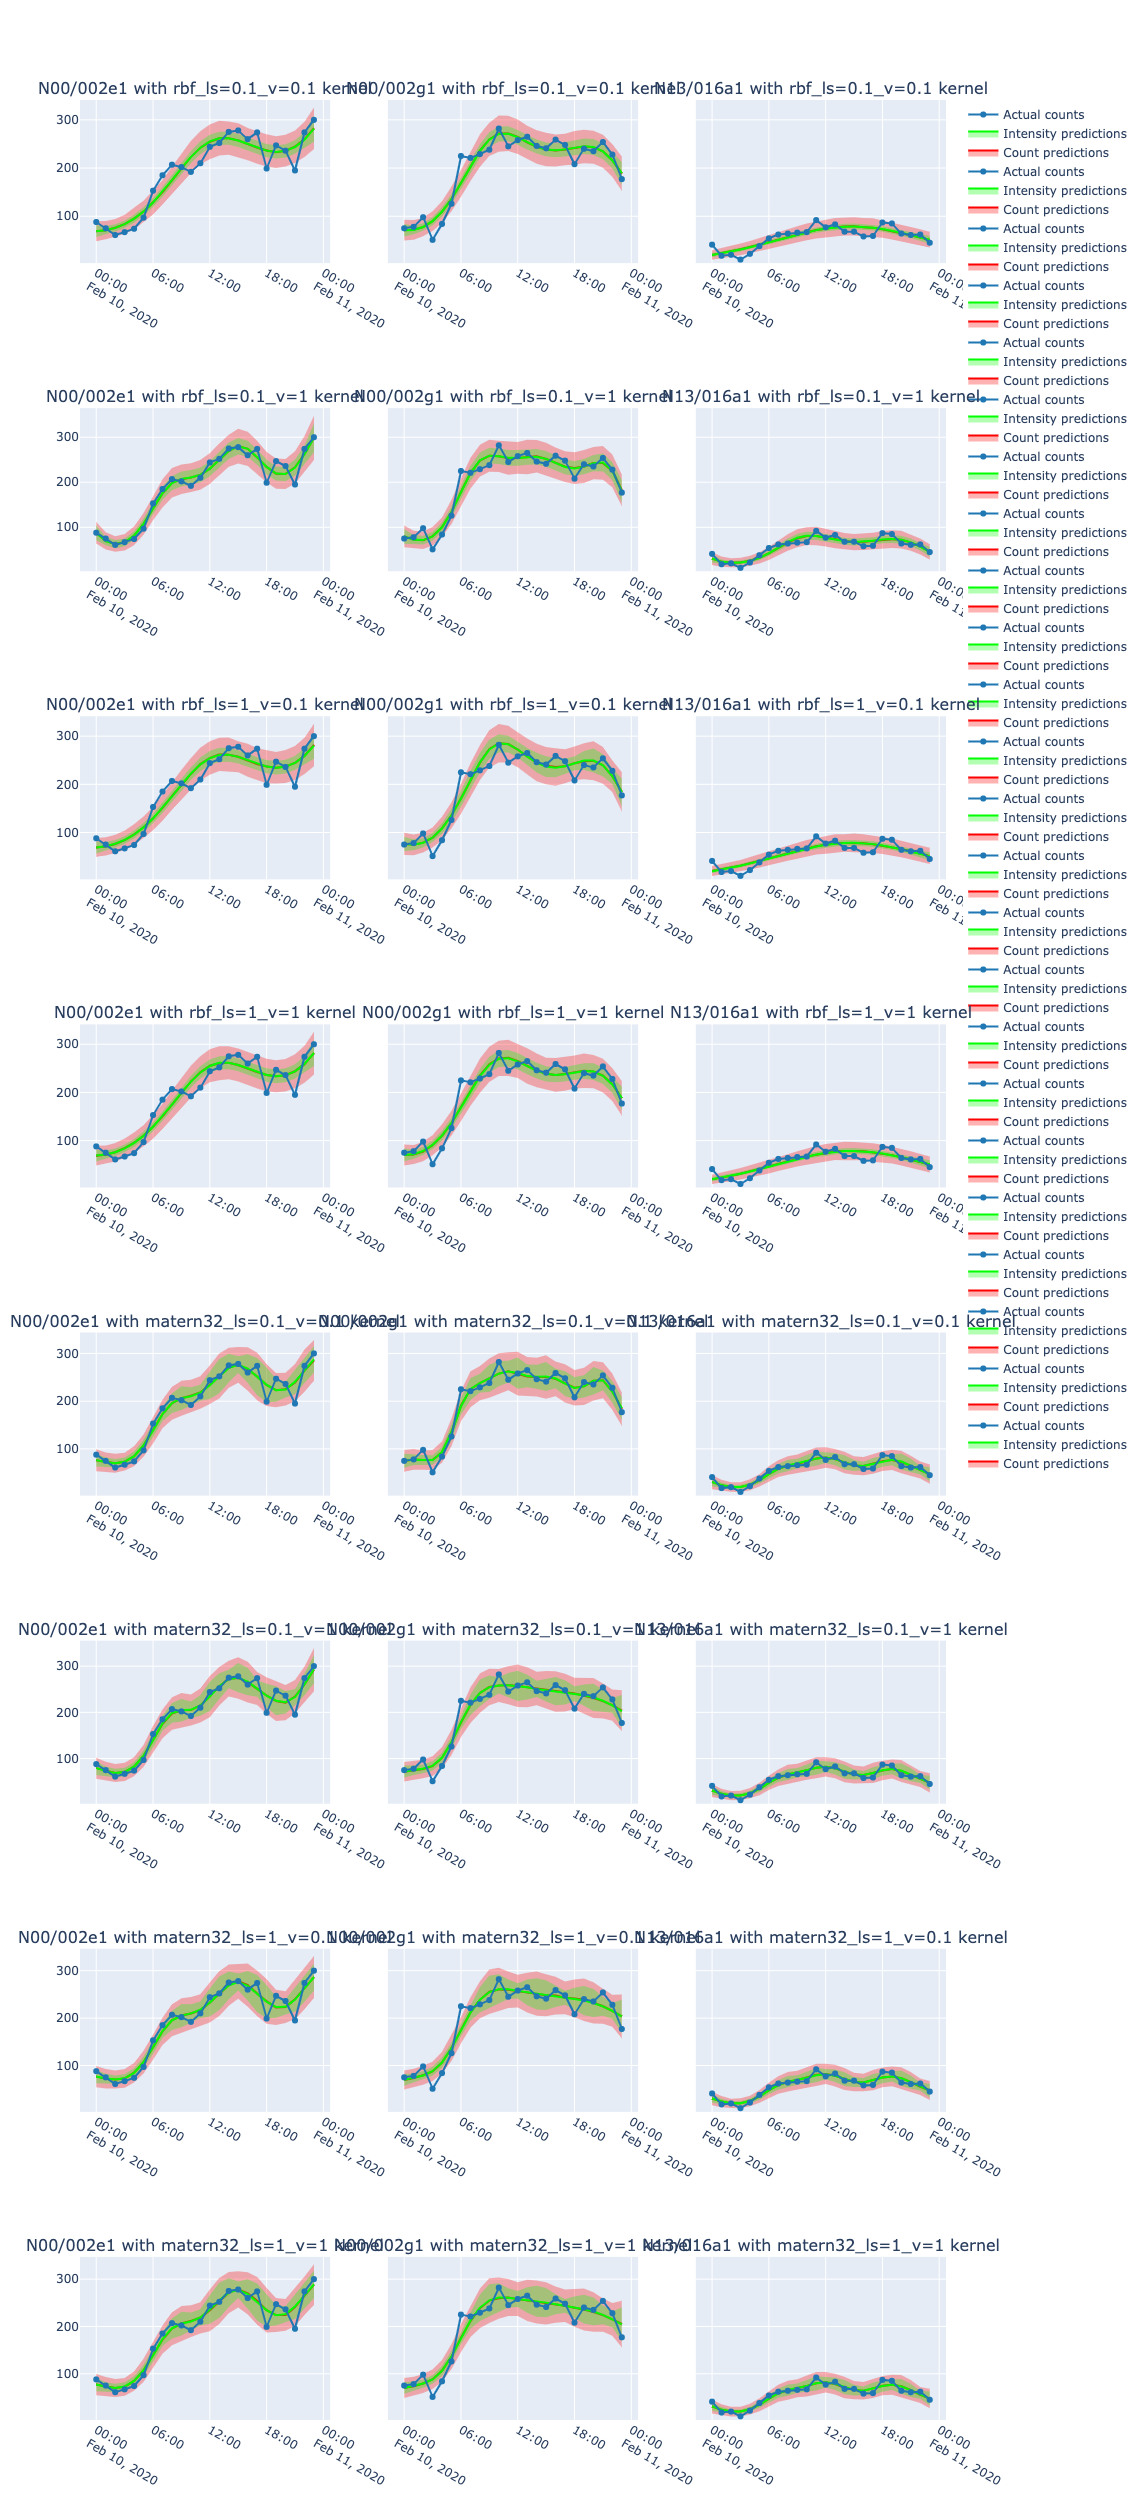

In [7]:
fig.update_layout(
    width=1500,
    height=2500
)
fig.show()